# Add injury to insult
#### A case study of murdering someone with the right choice of words

### Attacker
Nyah, level 5 witch (The Resentment)
**Skills** Diplomacy +14 (Bon Mot)

**Spells** DC 21; **3rd** Blindness, Biting Words; **2nd** Blistering Invective; **1st** Sure Strike x3 ; **Cantrips (3rd)** Evil Eye

### Attack routine
1. Bon Mot, Blistering Invective
2. Blindness, Evil Eye
3. Evil Eye or Sure Strike, Biting Words
4. Evil Eye, Sure Strike, Sustain Biting Words
5. Evil Eye, Sure Strike, Sustain Biting Words

### Assumptions
- The target attempts to clear neither Bon Mot nor Sickened
- No movement is needed; the target remains within 30ft at all time
- Spellcasting is not disrupted or obstructed in any way
- Ignoring damage dealt to other creatures by casting heightened blistering invective

In [1]:
diplomacy = 14
spell_DC = 21

blistering_invective_rank = 2
blindness_rank = 3
biting_words_rank = 3

## Targets

In [2]:
import numpy as np
import xarray
from pathfinder2e_stats import *

targets = xarray.Dataset(
    {
        "target": [
            "The Stag Lord",
            "Ettin",
            "Hill Giant",
            "Vampire Count",
            "Dweomercat",
        ],
        "level": ("target", [6, 6, 7, 6, 7]),
        "AC": ("target", [23, 21, 24, 24, 25]),
        "Will": ("target", [9, 12, 13, 17, 17]),
        "bonus_save_vs_magic": ("target", [0, 0, 0, 0, 1]),
        "sickened": ("target", [1, 0, 0, 0, 0]),
    }
)
targets["rank"] = (targets.level + 1) // 2  # For incapacitation and counteract
targets.to_pandas()

,level,AC,Will,bonus_save_vs_magic,sickened,rank
target,,,,,,
The Stag Lord,6,23,9,0,1,3
Ettin,6,21,12,0,0,3
Hill Giant,7,24,13,0,0,4
Vampire Count,6,24,17,0,0,3
Dweomercat,7,25,17,1,0,4


## Round 1: Bon Mot -> Blistering Invective

In [3]:
bon_mot = check(diplomacy, DC=targets.Will + 10 - targets.sickened)
bon_mot["Will_penalty"] = xarray.where(
    bon_mot.outcome == DoS.critical_success, 3,
    xarray.where(bon_mot.outcome == DoS.success, 2, 0)
)
bon_mot

<xarray.Dataset> Size: 9MB
Dimensions:       (target: 5, roll: 100000)
Coordinates:
  * target        (target) <U13 260B 'The Stag Lord' 'Ettin' ... 'Dweomercat'
Dimensions without coordinates: roll
Data variables:
    bonus         int64 8B 14
    DC            (target) int64 40B 18 22 23 27 27
    natural       (roll) int64 800kB 5 5 7 7 1 5 3 2 ... 10 18 15 15 4 16 15 5
    outcome       (roll, target) int64 4MB 1 0 0 0 0 1 0 0 0 ... 1 1 1 1 0 0 0 0
    Will_penalty  (roll, target) int64 4MB 2 0 0 0 0 2 0 0 0 ... 2 2 2 2 0 0 0 0
Attributes:
    keen:          False
    fortune:       False
    misfortune:    False
    hero_point:    False
    map_outcomes:  {}
    legend:        {-2: 'no_roll', -1: 'critical_failure', 0: 'failure', 1: '...

In [4]:
sickened = [
    targets.sickened
]
will = [
    targets.Will
    + targets.bonus_save_vs_magic
    - np.maximum(sickened[0], bon_mot.Will_penalty)
]

blistering_invective = damage(
    check(will[0], DC=spell_DC),
    Damage("fire", blistering_invective_rank // 2 * 2, 6, persistent=True, basic_save=True),
    persistent_damage_rounds=5
).rename({"persistent_round": "round"})

blistering_invective_damage = blistering_invective["persistent_damage"].where(
    blistering_invective["apply_persistent_damage"], 0
).sum("damage_type")
blistering_invective_damage.mean("roll").to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
round,,,,,
0,7.02551,5.21462,4.88363,3.32431,2.97543
1,2.10395,1.55991,1.46131,0.99105,0.88201
2,0.63610,0.46874,0.43869,0.30158,0.26935
3,0.19363,0.14138,0.13306,0.08976,0.08125
4,0.06112,0.04493,0.04232,0.02847,0.02573


In [5]:
frightened = xarray.where(
    blistering_invective.outcome == DoS.failure, 1,
    xarray.where(blistering_invective.outcome == DoS.critical_failure, 2, 0)
)
frightened.isel(roll=0)
frightened = np.maximum(0, frightened - blistering_invective["round"])

## Round 2: Blindness -> Evil Eye
Blindness is a rank 3+ spell with the incapacitation trait. level 7+ targets get the success of their saves one step better. Evil Eye is used to extend the duration.

In [6]:
# TODO: write tool to make bonus/penalty sums easier
def maximum(*args):
    out = args[0]
    for rhs in args[1:]:
        out = np.maximum(out, rhs)
    return out

will.append(
    targets.Will
    + targets.bonus_save_vs_magic
    - maximum(
        sickened[-1],
        bon_mot.Will_penalty,
        frightened.isel(round=1, drop=True),
    )
)
# TODO: pass incapacitation DataArray directly to check(..., incapacitation=...)
incapacitation = targets["rank"] > blindness_rank
blindness = check(will[-1], DC=spell_DC)
blindness["outcome"] = np.minimum(DoS.critical_success, blindness.outcome + incapacitation)

# In case of simple success, we use Evil Eye to extend the blindness for the whole combat
blindness["need_evil_eye"] = blindness.outcome == DoS.success
blindness["blind"] = blindness.outcome < DoS.critical_success
blindness

<xarray.Dataset> Size: 10MB
Dimensions:        (target: 5, roll: 100000)
Coordinates:
  * target         (target) <U13 260B 'The Stag Lord' 'Ettin' ... 'Dweomercat'
Dimensions without coordinates: roll
Data variables:
    bonus          (target, roll) int64 4MB 7 7 7 7 8 7 8 ... 16 16 18 16 16 18
    DC             int64 8B 21
    natural        (roll) int64 800kB 15 19 4 2 18 9 12 17 ... 11 9 14 15 5 6 15
    outcome        (roll, target) int64 4MB 1 1 2 2 2 1 2 2 ... 1 1 2 1 1 2 2 2
    need_evil_eye  (roll, target) bool 500kB True True False ... False False
    blind          (roll, target) bool 500kB True True False ... False False
Attributes:
    keen:          False
    fortune:       False
    misfortune:    False
    hero_point:    False
    map_outcomes:  {}
    legend:        {-2: 'no_roll', -1: 'critical_failure', 0: 'failure', 1: '...

In [7]:
def evil_eye(will_bonus, spell_DC, mask=None):
    c = check(will_bonus, DC=spell_DC)
    if mask is not None:
        c = c.where(mask, DoS.no_roll)
    return xarray.where(
        c.outcome == DoS.critical_failure, 2,
        xarray.where(c.outcome == DoS.failure, 1, 0),
    )

sickened.append(
    np.maximum(sickened[-1], evil_eye(will[-1], spell_DC))
)

In [8]:
blindness.mean("roll")[["blind", "need_evil_eye"]].to_pandas()

,blind,need_evil_eye
target,,
The Stag Lord,0.95010,0.28868
Ettin,0.93320,0.45995
Hill Giant,0.41632,0.36606
Vampire Count,0.69561,0.50009
Dweomercat,0.14526,0.09500


### Round 3: Evil Eye or Sure Strike -> Biting Words
If the target scored a simple success vs. Blindness in round 2, extend its duration with Evil Eye.
Otherwise, cast Sure Strike. Then, cast Biting Words.
### Round 4 and 5: Evil Eye -> Sure Strike -> sustain Biting Words

In [9]:
for rnd in range(3, 6):
    will.append(
        targets.Will
        + targets.bonus_save_vs_magic
        - np.maximum(sickened[-1], bon_mot.Will_penalty)
    )
    evil_eye_mask = blindness.need_evil_eye if rnd == 3 else None
    sickened.append(
        np.maximum(
            sickened[-1],
            evil_eye(will[-1], spell_DC, mask=evil_eye_mask)
        )
    )

assert len(will) == 5
assert len(sickened) == 5

will = xarray.concat(will, dim="round")
sickened = xarray.concat(sickened, dim="round")

In [10]:
off_guard = xarray.concat(
    [
        xarray.DataArray(False),
        xarray.where(blindness.blind, 2, 0).expand_dims(round=4),
    ],
    dim="round"
)
AC = targets.AC - np.maximum(frightened, sickened) - off_guard
AC

<xarray.DataArray (target: 5, roll: 100000, round: 5)> Size: 20MB
array([[[21, 20, 20, 20, 19],
        [22, 20, 19, 19, 19],
        [22, 20, 20, 20, 20],
        ...,
        [22, 20, 20, 20, 19],
        [21, 19, 19, 19, 19],
        [22, 20, 19, 19, 19]],

       [[20, 19, 19, 19, 18],
        [21, 21, 21, 20, 20],
        [21, 19, 19, 19, 19],
        ...,
        [21, 19, 19, 18, 18],
        [20, 18, 18, 18, 18],
        [21, 19, 18, 18, 18]],

       [[23, 24, 24, 24, 23],
        [24, 24, 24, 23, 23],
        [24, 22, 22, 22, 22],
        ...,
        [24, 22, 21, 21, 21],
        [23, 21, 20, 20, 20],
        [24, 24, 24, 24, 23]],

       [[23, 24, 24, 24, 23],
        [24, 24, 24, 23, 23],
        [24, 22, 22, 22, 22],
        ...,
        [24, 22, 22, 22, 21],
        [23, 21, 20, 20, 20],
        [24, 24, 24, 24, 24]],

       [[25, 25, 25, 25, 24],
        [25, 25, 25, 24, 24],
        [25, 25, 25, 25, 25],
        ...,
        [25, 25, 25, 25, 24],
        [24, 24, 24, 24, 24],
        [25, 25, 25, 25, 25]]])
Coordinates:
  * target   (target) <U13 260B 'The Stag Lord' 'Ettin' ... 'Dweomercat'
Dimensions without coordinates: roll, round

In [11]:
# TODO allow check(... fortune=...) with DataArray parameter
biting_words_check = check(spell_DC - 10, DC=AC, dims={"fortune": 2})
biting_words_check["outcome"] = xarray.concat(
    [
        xarray.DataArray([DoS.no_roll, DoS.no_roll], dims=["round"]),
        xarray.where(
            blindness.need_evil_eye,
            biting_words_check["outcome"].isel(round=2, fortune=0),
            biting_words_check["outcome"].isel(round=2).max("fortune"),
        ),
        biting_words_check["outcome"].isel(round=[3, 4]).max("fortune"),
    ],
    dim="round",
)

biting_words_damage = damage(
    biting_words_check,
    Damage("sonic", biting_words_rank * 2, 6)
).total_damage
biting_words_damage

<xarray.DataArray 'total_damage' (round: 5, roll: 100000, target: 5)> Size: 20MB
array([[[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        ...,
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0]],

       [[ 0,  0,  0,  0,  0],
        [ 0, 21, 21, 21, 21],
        [27, 30, 27, 27, 27],
        ...,
        [19, 19,  0, 19,  0],
        [42, 42,  0,  0, 23],
        [19, 19, 19, 19, 19]],

       [[26, 26,  0,  0,  0],
        [21, 21, 21, 21, 21],
        [27, 30, 27, 27, 27],
        ...,
        [19, 19, 19, 19,  0],
        [42, 42, 42, 42, 23],
        [48, 48, 19, 19, 19]],

       [[26, 26,  0,  0,  0],
        [21, 21, 21, 21, 21],
        [27, 30, 27, 27, 27],
        ...,
        [19, 19, 19, 19,  0],
        [42, 42, 42, 42, 23],
        [48, 48, 19, 19, 19]]])
Coordinates:
  * target   (target) <U13 260B 'The Stag Lord' 'Ettin' ... 'Dweomercat'
Dimensions without coordinates: round, roll

In [12]:
final = xarray.Dataset(
    {
        "AC_debuff": AC - targets.AC + targets.sickened,
        "Will_debuff": will - targets.Will - targets.bonus_save_vs_magic + targets.sickened,
        "blind": blindness.blind,
        "need_evil_eye": blindness.need_evil_eye,
        "blistering_invective": blistering_invective_damage,
        "biting_words": biting_words_damage,
        "total_damage": blistering_invective_damage + biting_words_damage,
    }
).transpose("target", "roll", "round")
final

<xarray.Dataset> Size: 101MB
Dimensions:               (target: 5, roll: 100000, round: 5)
Coordinates:
  * target                (target) <U13 260B 'The Stag Lord' ... 'Dweomercat'
Dimensions without coordinates: roll, round
Data variables:
    AC_debuff             (target, roll, round) int64 20MB -1 -2 -2 -2 ... 0 0 0
    Will_debuff           (target, roll, round) int64 20MB -1 -1 -1 -1 ... 0 0 0
    blind                 (target, roll) bool 500kB True True ... False False
    need_evil_eye         (target, roll) bool 500kB True True ... False False
    blistering_invective  (target, roll, round) int64 20MB 12 14 0 0 ... 0 0 0 0
    biting_words          (target, roll, round) int64 20MB 0 0 0 26 ... 19 19 19
    total_damage          (target, roll, round) int64 20MB 12 14 0 ... 19 19 19

In [13]:
final.mean("roll").sum("round")[["blistering_invective", "biting_words", "total_damage"]].to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
blistering_invective,10.02031,7.42958,6.95901,4.73517,4.23377
biting_words,65.43162,74.51494,50.17379,50.35732,44.54803
total_damage,75.45193,81.94452,57.13280,55.09249,48.78180


In [14]:
final.mean("roll")["total_damage"].to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
round,,,,,
0,7.02551,5.21462,4.88363,3.32431,2.97543
1,2.10395,1.55991,1.46131,0.99105,0.88201
2,20.71601,22.43364,15.33382,14.73307,14.51439
3,22.70747,26.23826,17.66425,17.93826,15.14075
4,22.89899,26.49809,17.78979,18.10580,15.26922


array([[<Axes: title={'center': 'The Stag Lord'}>,
        <Axes: title={'center': 'Ettin'}>],
       [<Axes: title={'center': 'Hill Giant'}>,
        <Axes: title={'center': 'Vampire Count'}>],
       [<Axes: title={'center': 'Dweomercat'}>, <Axes: >]], dtype=object)

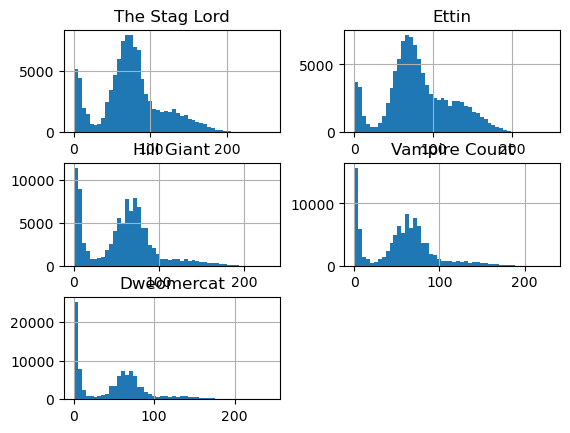

In [43]:
final.sum("round")["total_damage"].T.to_pandas().hist(bins=50)

In [15]:
final.mean("roll")[["blind", "need_evil_eye"]].to_pandas().T

target,The Stag Lord,Ettin,Hill Giant,Vampire Count,Dweomercat
blind,0.95010,0.93320,0.41632,0.69561,0.14526
need_evil_eye,0.28868,0.45995,0.36606,0.50009,0.09500


array([[<Axes: title={'center': 'The Stag Lord'}>,
        <Axes: title={'center': 'Ettin'}>],
       [<Axes: title={'center': 'Hill Giant'}>,
        <Axes: title={'center': 'Vampire Count'}>],
       [<Axes: title={'center': 'Dweomercat'}>, <Axes: >]], dtype=object)

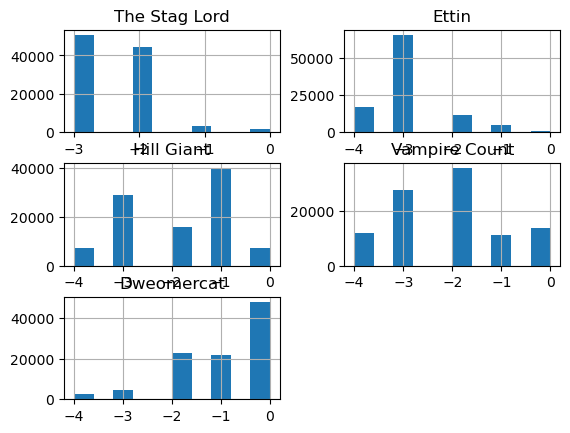

In [36]:
final.min("round")["AC_debuff"].T.to_pandas().hist()

array([[<Axes: title={'center': 'The Stag Lord'}>,
        <Axes: title={'center': 'Ettin'}>],
       [<Axes: title={'center': 'Hill Giant'}>,
        <Axes: title={'center': 'Vampire Count'}>],
       [<Axes: title={'center': 'Dweomercat'}>, <Axes: >]], dtype=object)

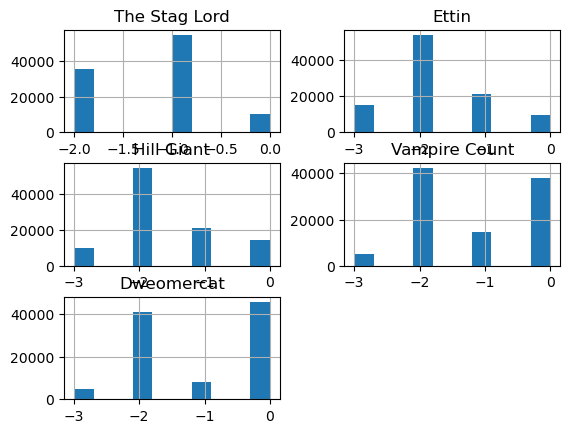

In [38]:
final.min("round")["Will_debuff"].T.to_pandas().hist()

In [ ]:
final